# Bayesian analysis of polling preference allocations

## Set-up

In [1]:
# system imports
from pathlib import Path
from typing import Any, NotRequired, TypedDict
from functools import cache

# analytic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az  # type: ignore[import-untyped]
import pymc as pm  # type: ignore[import-untyped]

In [2]:
# local import
import bayes_tools
import plotting
from common import (
    MIDDLE_DATE,
    VOTING_INTENTION,
    ensure,
)
from data_capture import retrieve

In [3]:
# plotting related
SHOW = False  # show charts in the notebook

# model diagram
MODEL_DIR = "../model-images/"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

### Check operating environment

In [4]:
%load_ext watermark
%watermark --python --machine --conda --iversions --watermark

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 8.32.0

conda environment: pymc

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

arviz     : 0.20.0
pymc      : 5.20.1
matplotlib: 3.10.0
pandas    : 2.2.3
numpy     : 1.26.4

Watermark: 2.5.0



## Get data
Limit to firms with more than N polls in the past year (or so).

In [5]:
def get_data(minimum_poll_count: int = 6) -> pd.DataFrame:
    """Retrieve data after running the data capture notebook."""

    retrieved = retrieve()
    ensure(retrieved, "You must run the data capture notebook every day.")

    vi = retrieved[VOTING_INTENTION]
    vi = plotting.amalgamate_other(vi)
    vi.index = vi[MIDDLE_DATE]

    one_year_ago = pd.Period(  # actually 13 months ago
        pd.Timestamp.now() - pd.DateOffset(years=1) - pd.DateOffset(months=1), freq="D"
    )
    vi = vi.loc[vi.index >= one_year_ago]
    count = vi.Brand.value_counts()
    count = count[count >= minimum_poll_count]
    keep = count.index
    vi = vi[vi.Brand.isin(keep)]    

    return vi


vi_data = get_data()
vi_data.columns

Index(['Date', 'Brand', 'Interview mode', 'Sample size', 'Primary vote L/NP',
       'Primary vote ALP', 'Primary vote GRN', 'Primary vote ONP',
       'Primary vote UAP', 'Primary vote OTH', '2pp vote ALP', '2pp vote L/NP',
       'First Date', 'Mean Date', 'Last Date', 'Primary vote Other'],
      dtype='object')

## Build a model

In [6]:
ELECT_YEAR = '2022'
GREEN_FLOW = 85.66
OTHER_FLOW = 46.37

def build_model(
    tpp_labor: list[float],
    pv_labor: list[float],
    pv_green: list[float],
    pv_other: list[float],
) -> pm.Model:
    """Build a PyMC3 model for identifying preference flows in polling data."""

    with pm.Model() as model:
        # Priors
        common = {"sigma": 0.125, "lower": 0.0, "upper": 1.0}  # SD and truncated bounds
        share_green = pm.TruncatedNormal("share_green", mu=GREEN_FLOW/100.0, **common)
        share_other = pm.TruncatedNormal("share_other", mu=OTHER_FLOW/100.0, **common)

        # Likelihood
        pm.Normal(
            "observed", 
            mu=pv_labor + share_green * pv_green + share_other * pv_other,
            observed = tpp_labor,
        )

    return model
    

In [7]:
class SampleSettings(TypedDict):
    """The settings for the Bayesian model."""

    draws: int
    tune: int
    cores: int
    chains: int
    nuts_sampler: str
    nuts: NotRequired[dict[str, Any]]  # Requires Python 3.11


def sampler_settings() -> SampleSettings:
    """Return the settings for sampling."""

    core_chains = 5
    settings: SampleSettings = {
        "draws": 2_000,  # number of samples per core
        "tune": 3_000,  # number of tuning steps per core
        "cores": core_chains,
        "chains": core_chains,
        "nuts_sampler": "numpyro",
    }

    return settings


## Run the model

In [8]:
def _get_var(inference, var_name: str) -> pd.DataFrame:
    """Extract the chains/draws for a specified var_name."""

    return (
        az.extract(inference, var_names=var_name)
        .transpose("sample", ...)
        .to_dataframe()[var_name]
        .unstack(level=1)
        .T
    )

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Max r_hat: 1.01
Min ess: 1201.0
Divergences: 0


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Max r_hat: 1.0
Min ess: 1379.0
Divergences: 0


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Max r_hat: 1.0
Min ess: 1435.0
Divergences: 0


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Max r_hat: 1.0
Min ess: 1482.0
Divergences: 0


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Max r_hat: 1.0
Min ess: 1174.0
Divergences: 0


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Max r_hat: 1.0
Min ess: 1764.0
Divergences: 0


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Max r_hat: 1.0
Min ess: 1495.0
Divergences: 0


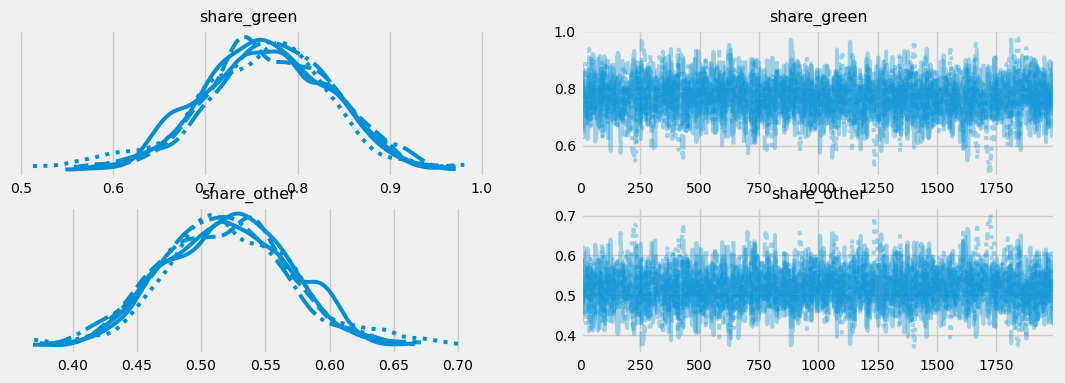

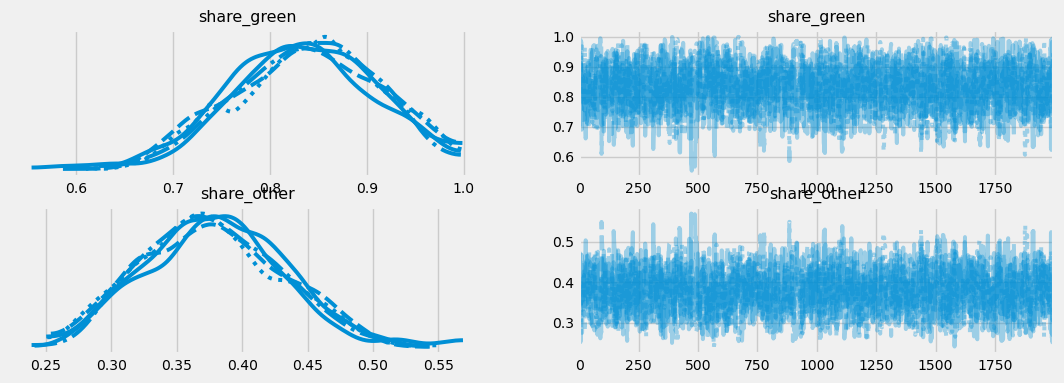

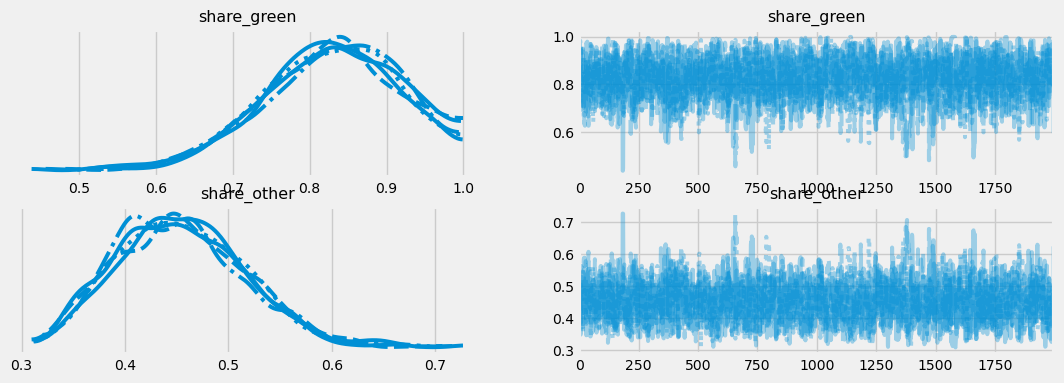

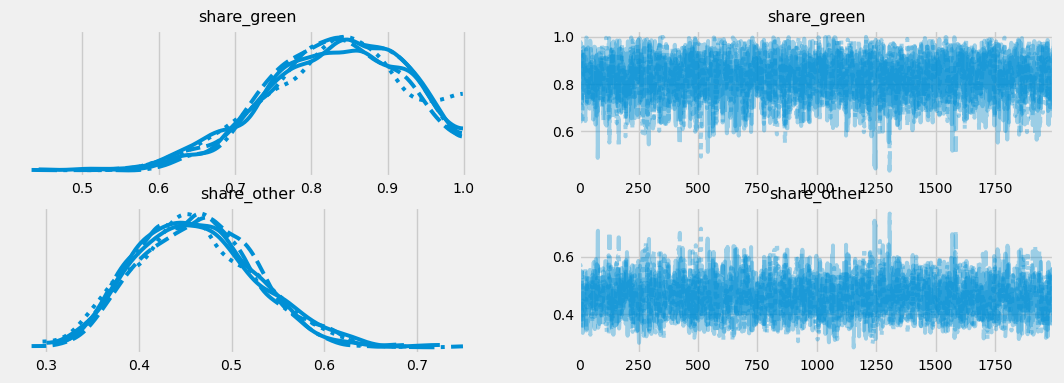

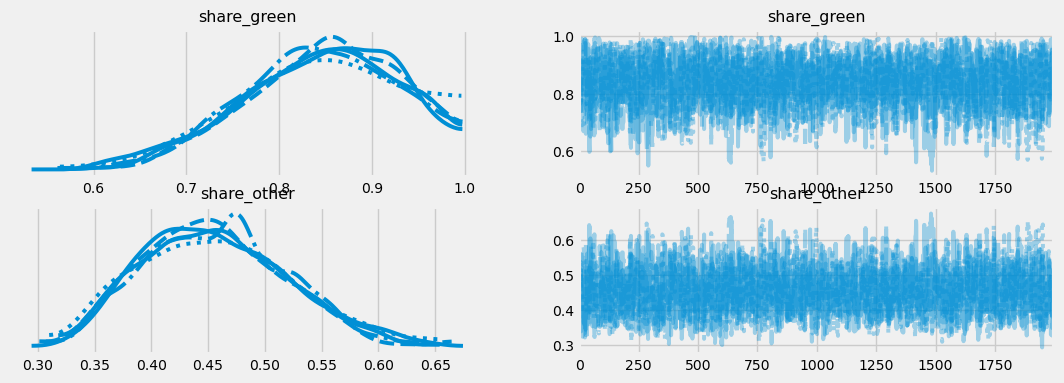

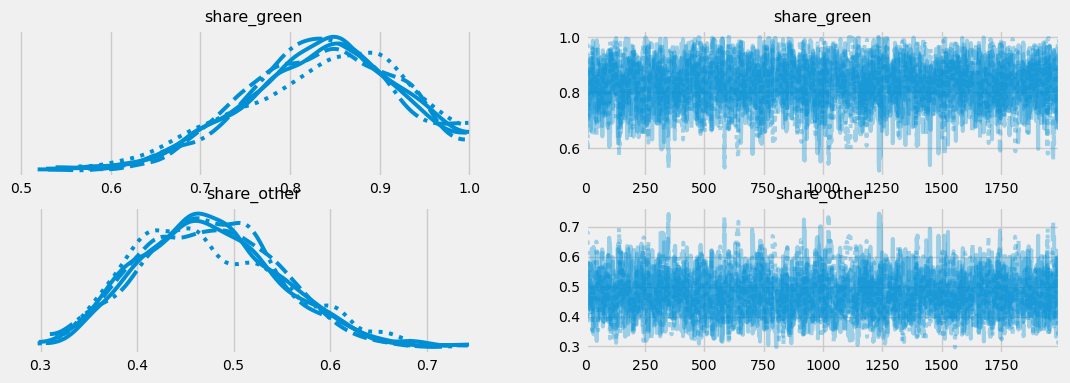

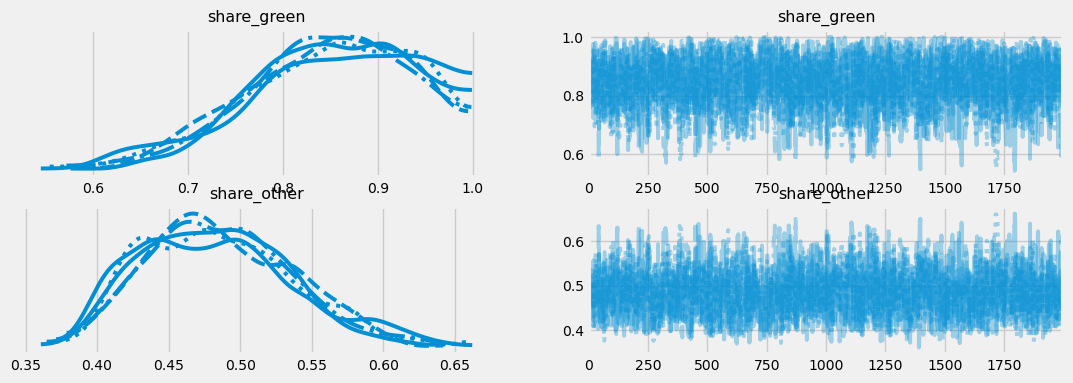

In [9]:
greens = {}
other = {}
problems = {}
poll_count = {}
for brand in vi_data.Brand.unique():
    selected = vi_data[vi_data.Brand == brand]
    poll_count[brand] = len(selected)
    tpp_labor = selected['2pp vote ALP'].tolist()
    pv_labour = selected['Primary vote ALP'].tolist()
    pv_green = selected['Primary vote GRN'].tolist()
    pv_other = selected['Primary vote Other'].tolist()

    model = build_model(tpp_labor, pv_labour, pv_green, pv_other)
    sampling = sampler_settings()
    idata, glitches = bayes_tools.draw_samples(model, **sampling)
    other[brand] = _get_var(idata, "share_other")
    greens[brand] = _get_var(idata, "share_green")
    if glitches:
        problems[brand] = glitches
    

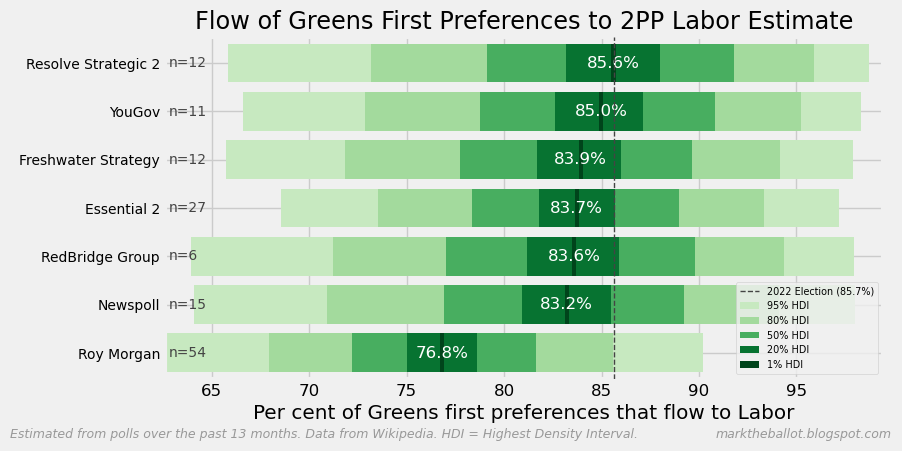

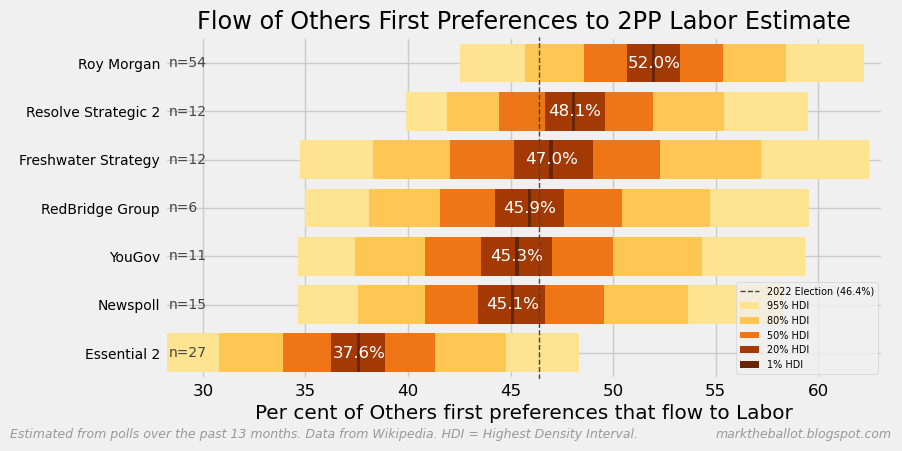

In [10]:
def plot_prefs():
    percents = [2.5, 10, 25, 40, 49.5]
    intensities = [
        (p - min(percents)) / (max(percents) - min(percents)) for p in percents
    ]
    min_intensity = 0.25
    intensity_fracs = [c * (1.0 - min_intensity) + min_intensity for c in intensities]


    labels = ["Greens", "Others"]
    datasets = [greens, other]
    colors = ["Greens", "YlOrBr"]
    e2022 = [GREEN_FLOW, OTHER_FLOW]

    for label, data, palette, previous in zip(labels, datasets, colors, e2022):
        color = plt.get_cmap(palette)
        linear_data = {}

        # print central tendency
        middle = {}
        for brand in data:
            linear_data[brand] = data[brand].unstack()
            middle[brand] = (linear_data[brand].median() * 100).round(1)
        mid = pd.Series(middle).sort_values()

        # plot
        minimum = 100
        _fig, ax = plt.subplots()
        for i, p in enumerate(percents):
            quants = p, 100 - p
            for x, brand in enumerate(mid.index):
                leg = "_" if x > 0 else f"{quants[1] - quants[0]:0.0f}% HDI"
                lower, upper = [linear_data[brand].quantile(q=q/100.0) * 100 for q in quants]
                minimum = min(minimum, lower)
                intensity = intensity_fracs[i]
                ax.barh(
                    brand,
                    width=upper - lower,
                    left=lower,
                    color=color(intensity),
                    label=leg,
                    zorder=i + 1,
                )
        for brand in mid.index:
            ax.text(
                middle[brand],
                brand,
                f"{middle[brand]}%",
                ha="center",
                va="center",
                color="white",
                zorder=100+i,
                fontfamily="sans-serif",
            )
            ax.text(
                minimum+0.2,
                brand,
                f"n={poll_count[brand]}",
                ha="left",
                va="center",
                color="#444444",
                zorder=120+i,
                fontfamily="sans-serif",
                fontsize="small",
            )
        ax.axvline(
            x=previous,
            color="#444444",
            linestyle="--",
            linewidth=1,
            zorder=220,
            label=f"{ELECT_YEAR} Election ({previous:0.1f}%)",
        )
        ax.tick_params(axis="y", labelsize="small")
        plotting.finalise_plot(
            ax,
            title=f"Flow of {label} First Preferences to 2PP Labor Estimate",
            xlabel=f"Per cent of {label} first preferences that flow to Labor",
            legend={"loc": "lower right", "fontsize": "xx-small"},
            lfooter="Estimated from polls over the past 13 months. "
            + "Data from Wikipedia. HDI = Highest Density Interval.",
            rfooter="marktheballot.blogspot.com",
            rheader=problems if problems else None,
            show=True,
        )
    

plot_prefs()

## Finished

In [11]:
print("Finished")

Finished
